In [ ]:
%reset

# 新段落

In [ ]:
## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import math
import time as t
#from pde import CartesianGrid, solve_laplace_equation


# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# torch.set_default_dtype(torch.float32)
torch.set_default_dtype(torch.float64)
#torch.manual_seed(13)


#grid = CartesianGrid([[1, 9]] * 2, 80)
#bcs = [{"value": "log((x*x+y*y)**0.5)"}, {"value": "log((x*x+y*y)**0.5)"}]
#bcs = [{"value": "3"}, {"value": "3"}]
#res = solve_laplace_equation(grid, bcs)

#Ps = torch.tensor(grid.cell_coords)
#u_true = torch.tensor(res.data)

#train_pts = 50
#train_idx = torch.randperm(len(u_true.flatten()))[:train_pts]
#X = Ps.flatten(0,1)[train_idx]
#U = u_true.flatten()[train_idx]



Using cuda device


Text(0.5, 1.0, 'True solution')

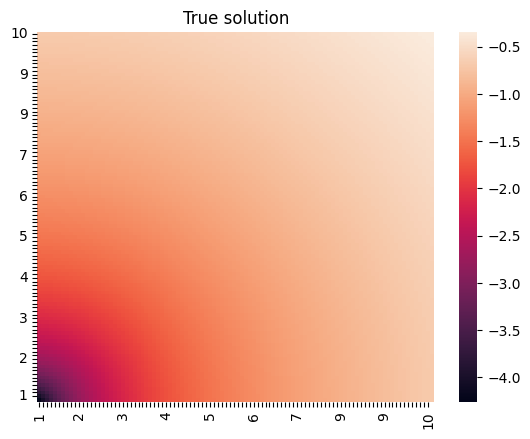

In [ ]:
n_axis = 100
a=0.01
b=0.5
axis = torch.linspace(a, b, n_axis, device=device)
axis_r = torch.linspace(b, a, n_axis, device=device)
#axis = torch.linspace(0.01, 1., n_axis, device=device)
Ps = torch.cartesian_prod(axis_r, axis)
xx, yy = torch.meshgrid((axis_r, axis), indexing="ij")

def u(x,y):
  return (torch.log((x*x+y*y)**0.5))

#def u(x,y):
#  return ((x*x-y*y))
step = (b-a)/99
lable = [a]+[' ']*8+[a+9*step]+[' ']*9+[a+19*step]+[' ']*9+[a+29*step]+[' ']*9+[a+39*step]+[' ']*9+[a+49*step]+[' ']*9+[a+59*step]+[' ']*9+[a+69*step]+[' ']*9+[a+79*step]+[' ']*9+[a+89*step]+[' ']*9+[b]
lable = list(lable)
lable = [1]+[' ']*9+[2]+[' ']*10+[3]+[' ']*10+[4]+[' ']*10+[5]+[' ']*10+[6]+[' ']*10+[7]+[' ']*10+[9]+[' ']*10+[9]+[' ']*10+[10]
udata = u(xx,yy)
sn.heatmap(udata.cpu(), xticklabels=lable, yticklabels=lable[::-1])
plt.title("True solution")

In [ ]:
maskXl = abs(Ps[:,0]-a) < 1e-10
maskXr = abs(Ps[:,0]-b) < 1e-10
maskYl = abs(Ps[:,1]-a) < 1e-10
maskYr = abs(Ps[:,1]-b) < 1e-10
#mask0 = abs(Ps[:,0]+Ps[:,1]) <1e-10
mask = maskXl+maskXr+maskYl+maskYr
#mask[0] = False
X = Ps[mask]
U = u(*X.unbind(1)).view(-1, 1)
mask.shape

torch.Size([10000])

In [ ]:
U.shape

torch.Size([396, 1])

In [ ]:

def Phi(c,X):
  c1, c2 = c.chunk(2)
  c1 = c1.unsqueeze(1) * torch.tensor([1+1.j,1-1.j])
  c2 = c2.unsqueeze(1) * torch.tensor([1-1.j,1+1.j])
  cc = torch.cat([c1,c2])
  return cc.inner(X.to("cpu")).exp().to(device)

def NLML(X,U,c,Sigma,sigma0):
  phi = Phi(c,X)
  A = phi @ phi.H + torch.diag_embed((sigma0-Sigma).exp()).to(device)
  #print(torch.linalg.eig(A)[0])
  #A = phi @ phi.H + torch.diag_embed((sigma0).exp()).to(device)
  #print(sigma0)
  L = torch.linalg.cholesky(A)
  alpha = torch.linalg.solve_triangular(L, phi @ U, upper=False)
  nlml = 1/(2*sigma0.exp()) * (U.norm().square() - alpha.norm().square())
  nlml += (phi.shape[1] - phi.shape[0])/2 * sigma0
  nlml += L.diag().real.log().sum()
  nlml += 1/2 * Sigma.sum()
  return nlml

m = 10
Sigma = torch.full((2*m,), -np.log(2*m)).requires_grad_()
#sigma0 = torch.tensor(np.log(1e-5)).requires_grad_()
sigma0 = torch.tensor(np.log(1e-5))
c = (1*torch.randn(2*m, dtype=torch.complex128)).requires_grad_()
U = U.to(torch.complex128).reshape(-1,1)
X = X.to(torch.complex128)

def train(opt, sched, epoch_max = 1000):
  for epoch in range(epoch_max):
    nlml = NLML(X,U,c,Sigma,sigma0)

    print(f'Epoch {epoch+1}/{epoch_max}\tNLML {nlml.detach():.3f}', end='\r')

    opt.zero_grad()
    nlml.backward()
    opt.step()
    sched.step()


In [ ]:
opt = torch.optim.Adam([c,Sigma,sigma0], lr = 1e-2)
#opt = torch.optim.Adam([c], lr = 1e-2)
sched = torch.optim.lr_scheduler.StepLR(opt,3000,gamma=0.1)
train(opt,sched,3000)

In [ ]:
def predict(X_, X,U,c,Sigma,sigma0):
  with torch.no_grad():
    phi = Phi(c,X)
    A = phi @ phi.H + torch.diag_embed((sigma0-Sigma).exp()).to(device)
    L = torch.linalg.cholesky(A)
    alpha = torch.linalg.solve_triangular(L, phi @ U, upper=False)
    alpha1 = torch.linalg.solve_triangular(L.H, alpha, upper=True)
    phi_ = Phi(c,X_)
    return (phi_.H @ alpha1).real

In [ ]:
#X_ = Ps.flatten(0,1).to(torch.complex128)
X_ = Ps.to(torch.complex128)
u_pred = predict(X_, X, U, c, Sigma, sigma0)

In [ ]:
(u_pred.view_as(udata) - udata).square().mean().sqrt().item()

0.003581934714151174

In [ ]:
((u_pred.view_as(udata) - udata)/udata).square().mean().sqrt().item()

0.0019665374415368396

Text(0.5, 1.0, 'Predicted solution')

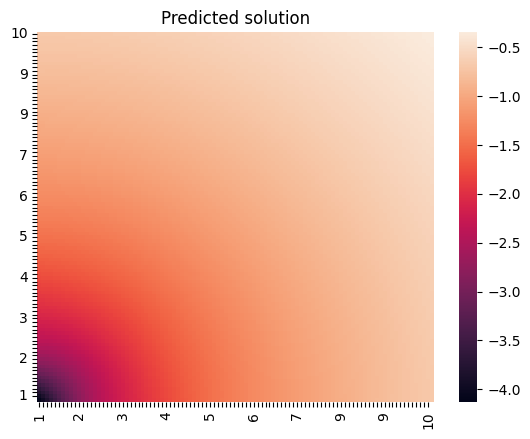

In [ ]:
sn.heatmap(u_pred.view_as(udata).cpu(), xticklabels=lable, yticklabels=lable[::-1])
plt.title("Predicted solution")

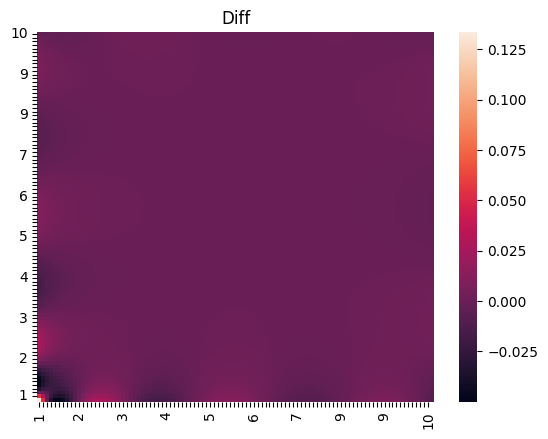

In [ ]:
diff = u_pred.view_as(udata) - udata
sn.heatmap(diff.to("cpu"), xticklabels=lable, yticklabels=lable[::-1])
plt.title("Diff");

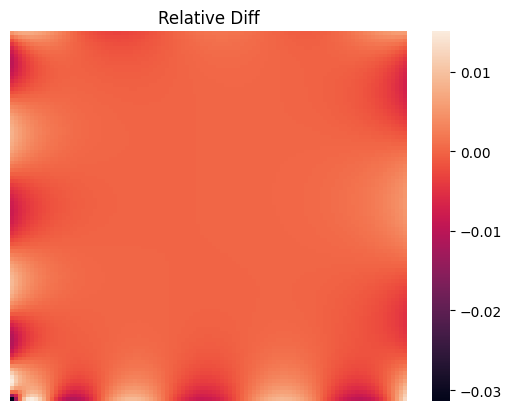

In [ ]:
rdiff = (u_pred.view_as(udata) - udata)/udata
sn.heatmap(rdiff.to("cpu"), xticklabels=False, yticklabels=False)
plt.title("Relative Diff");